**Vision Transformer (ViT)**

## 1. Abstract

* ViT를 이용하여 MNIST 데이터셋을 분류하기

## 2. Architecture

> 간단한 모델 파이프라인 및 구조 설명

### ViT 모델 파이프라인

1. 입력 이미지 → 패치 분할 → 패치 평탄화 및 임베딩
2. 패치 임베딩 + 위치 임베딩 → CLS 토큰 추가
3. Transformer 인코더:
  * 멀티 헤드 Self-Attention → 피드포워드 네트워크 → Layer Norm + Residual Connection (여러 층 반복)
4. CLS 토큰 출력 → 분류 헤드
5. 손실 계산 → 역전파 및 최적화 (pytorch lightning 에서자동수행)

## 3. Pipeline




> 자유롭게 논문에 소개된 모델을 활용하여, 데이터를 분석해 보세요!!



A. Import Libraries

In [1]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 18.3 MB/s eta 0:00:00


## 패키지 불러오기
* 패키지 설명
1. os : 파일 경로 관련 작업 할 때 사용되는 파이썬 표준 lib
2. torch : PyTorch 라이브러리, 텐서 연산과 딥러닝 모델 구축할 때 사용
3. nn : Pytorch에서 신경망 모듈을 정의할 때 사용하는 패키지
4. DataLoader : 데이터셋을 쉽게 다룰 수 있게 배치 단위로 데이터 로드
5. random_split : 데이터셋을 훈련/검증 데이터로 나눌 때 사용
6. datasets : 파이토치에 제공하는 데이터셋 모듈
7. transforms : 데이터에 대해 전처리 할 수 있는 기능
8. ToTensor : 이미지를 파이토치 텐서로 변환하는 기능
9. Lambda : 데이터를 람다 함수로 변환
10. pytorch_lightning: 파이토치의 코드 구조를 간소화해줌
11. einops : 복잡한 텐서 변환을 쉽게 할 수 있는 라이브러리

In [5]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda

device = 'cuda' if torch.cuda.is_available() else 'cpu'
import matplotlib.pyplot as plt
import pytorch_lightning as pl
torch.manual_seed(0)

# 시드 설정

In [2]:
import numpy as np

In [3]:
from einops.layers.torch import Reduce

B. Configuration

In [6]:
# MNIST 데이터셋의 train 데이터 불러오기  ( 총 60,000개 )
training_data = datasets.MNIST(
    root="data",
    download=True,
    transform=ToTensor()  # 데이터를 불러올 때 이미지 데이터를 파이토치 텐서로 변환
)

# MNIST 데이터셋의 test 데이터 불러오기 ( 총 10,000개 )
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
train_dataset, val_dataset = random_split(training_data, [55000, 5000])
# 학습 데이터셋을 학습 데이터와 검증데이터로 나눔


# 학습 파라미터 설정
learning_rate = 1e-3
batch_size = 128
epochs = 10

# 데이터셋을 batch_size 크기로 불러옴 (모델 훈련에 쓰임)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 902200.67it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 132318.60it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1097933.07it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3630746.86it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [7]:
# iter를사용해 반복자를 생성하고 다음 배치를 가져옴
# data : 배치 내의 이미지 데이터가 저장  / (batch_size, channel, width, height)의 텐서로 이루어짐
# MNIST 데이터셋의 레이블은 0부터 9까지
data, label = next(iter(train_dataloader))

C. Data Preprocessing & EDA

In [8]:
data.shape #[batch_size, channel, width, height]

torch.Size([128, 1, 28, 28])

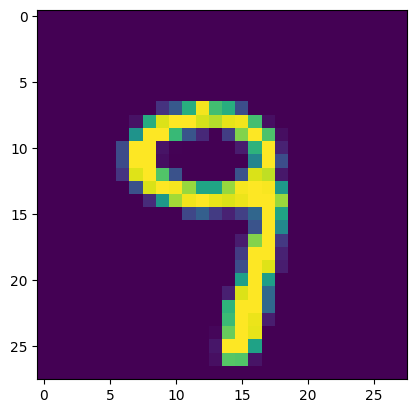

In [ ]:
# 흑백이미지는 원래 2차원 / 컬러 이미지는 3차원

plt.imshow(data[0].reshape(28,28)) # 시각화를 위해 2차원 배열로 변환

In [ ]:
label

tensor([9, 3, 5, 4, 7, 4, 9, 6, 8, 8, 7, 4, 8, 9, 4, 0, 6, 8, 9, 9, 3, 1, 3, 2,
        5, 0, 2, 1, 6, 5, 5, 4, 7, 4, 1, 8, 7, 3, 3, 5, 1, 6, 0, 1, 4, 4, 0, 0,
        7, 0, 6, 7, 8, 9, 2, 1, 0, 7, 9, 2, 6, 8, 7, 7, 2, 8, 8, 5, 7, 1, 9, 3,
        1, 2, 4, 8, 6, 5, 1, 6, 5, 6, 8, 8, 5, 0, 2, 7, 2, 5, 8, 7, 7, 7, 2, 7,
        8, 8, 7, 7, 0, 2, 9, 5, 5, 4, 6, 6, 2, 3, 3, 1, 5, 5, 1, 8, 8, 7, 6, 2,
        0, 7, 3, 9, 2, 1, 4, 7])

In [ ]:
data[0].shape

torch.Size([1, 28, 28])

D. Modelling

# [각 단계별 구현]

## 모델 input = Embedded Patches = Concat(Patch + CLS) + Postion Embedding

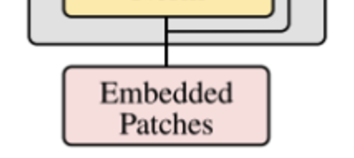

### Patch Embedding

* self-Attention 구현을 위해 이미지를 1차원으로 Flatten 해줘야함(self-attention은 1차원벡터를 입력으로 받아서 변환이 필요함)
* 이런 과정을 Patch라고 함
* 4*4 이미지만큼씩 자름
* [1,28,28] → [49, 16*1]개의 임베딩


In [ ]:
project = nn.Conv2d(1, 16, kernel_size= 4, stride=4)

# 4*4 크기의 패치를 받아들여 16차원 벡터로 임베딩 / 각각의 벡터들은 패치 하나의 특징을 담음
#in_chan = 1 (흑백 이미지이므로 input channel은 1개)
#self.emb_size = Channel * Patch Size * Patch Size = 1 * 4 * 4 = 16
#Kernel Size = Patch Size
#Stride = Patch Size (겹치지 않도록 같게 둠)
project(data[0].unsqueeze(0)).shape

torch.Size([1, 16, 7, 7])

### CLS 토큰을 Patch Embedding과 Concat
* CLS 토큰 : 문장의 시작을 알려주는 토큰
* Patch 과정을 거치면 이미지는 [batch_size, 49, 16]의 모양이되고, CLS 토큰의 모댱은 [batch_size, 1, 16]이 된다.
* 둘을 concat 하면  [batch_size, 49 +1 , 16]

In [ ]:
class EmbeddingLayer(nn.Module):
    def __init__(self,in_chan, img_size, patch_size,batch_size=128):
        super().__init__()
        self.num_patches = int(img_size / pow(patch_size, 2)) # 49
        self.emb_size = in_chan * patch_size * patch_size # 16
        self.project = nn.Conv2d(in_chan, self.emb_size, kernel_size= patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1,1,self.emb_size))
        # 학습이 가능해야하는 파라미터이므로 nn.Parameter 사용 / 모델 학습 과정에서 CLS 토큰의 값이조정
        self.positions = nn.Parameter(torch.randn(self.num_patches+ 1, self.emb_size)) # [50,16]
        # Position Embedding = patch와 cls Token을 concat하고 Position Embedding 벡터를 더 해줌, 학습 가능해야함

        ## Embedded Patches 완성 ~!


    def forward(self, x):
        x = self.project(x) # Conv2D 를 통해 패치로 나누고 패치 임베딩 / 결과는 [batch_size, emb_size, 7, 7]의 크기를 가진 텐서
        x = x.view(-1, 49, 16) # [batch_size, 49, 16]
        repeat_cls = self.cls_token.repeat(x.size()[0],1,1) #cls 토큰을 배치크기만큼 복사해서텐서로 만듦 [batch_size, 1 , 16] / 각 이미지에 대해 하나씩 추가됨
        x = torch.cat((repeat_cls, x), dim=1) # cls 토큰과 패치 임베딩 결합
        x += self.positions  # 각 패치와 CLS 토큰에 Position Embedding 더
        return x

## Norm, Multi-head Attention

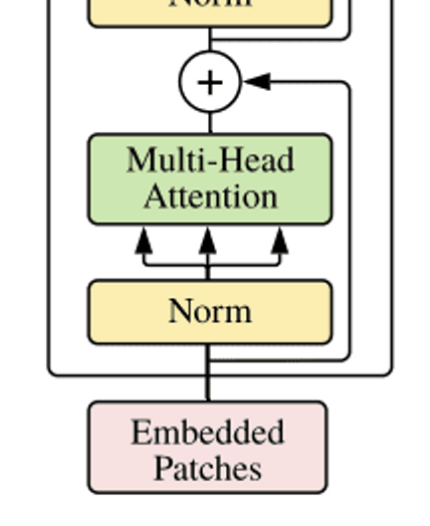

### layer Normalization
* Batch Norm => 각 Feature들을 Normalization
* Layer Norm => 배치 마다 Normalization
* 동일한 배치에 있는 시점의 시퀀스들을 모아서 정규화
* 시계열 데이터는 시점마다 다른 통계치가 존재한다는 특성이 있어서 첫번째 시퀀스들 끼리, 두번째 시퀀스들 끼리 등으로 하는게 효율적


In [ ]:

class Multihead(nn.Module):
    def __init__(self, emb_size, num_heads):
        super().__init__()
        self.multiheadattention = nn.MultiheadAttention(emb_size, num_heads, batch_first = True, dropout=0.2)
        self.query = nn.Linear(emb_size, emb_size)
        self.key = nn.Linear(emb_size, emb_size)
        self.value = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        attn_output, attention = self.multiheadattention(query, key, value)
        return attn_output, attention
        # attn_output : Attention 결과  / attention : 각 헤드 별 Attention Score


## FeedForwardBLock
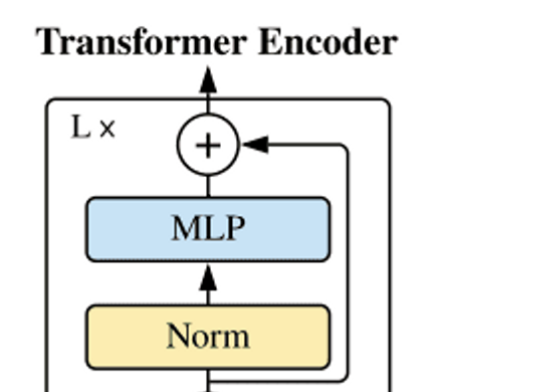

* 기존 트랜스포머와같이, 원래 임베딩 차원의 4배가 되도록 설정하고 원래 사이즈로 돌아오는 과정 (더 많은 특징 학습)
* BERT, GPT, ViT 모델에선 GELU를 사용, 네트워크가 깊어질수록 입력치에 가중치를 부여함

In [ ]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion = 4, drop_p = 0.2):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(), # Activation Function / 입력값이 0에 가까울 땐 선형적, 크거나 작으면 비선형적으로작동해 복잡한 패턴 학습
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size) # 원래크기로 축소 ( 64->16 차)
        )

## 모델 전체 구현

In [ ]:
class VIT(nn.Module):
    def __init__(self,emb_size = 16):
        super().__init__()
        self.embedding_layer = EmbeddingLayer(1, 28*28, 4)
        self.Multihead = Multihead(emb_size, 8)
        self.FFB = FeedForwardBlock(emb_size)
        self.norm = nn.LayerNorm(emb_size)

    def forward(self, x):
        x = self.embedding_layer(x)

        norm_x = self.norm(x) # layer normalization을 적용해서 데이터를 정규화 한 다음 어텐션에 통과
        multihead_output, attention = self.Multihead(norm_x)

        #residual Function / attention의 출력을 원래 입력 x와 더해줌
        output = multihead_output + x

        norm_output = self.norm(output)  #다시 layer normalization 진행
        FFB = self.FFB(norm_output)  # feedforward 통과 (기울기 소실, 폭발 문제를 막기 위해 정규화된 값 사용)

        final_out = FFB + output # 정규화되지 않은 output을 더하는 이유 : residual connection에서 입력 정보의 보존때문

        return final_out, attention





## Encoder L x

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, n_layers: 5, ):  # VIT 레이어 5개 쌓아서 transformer encoder 구성
        super().__init__()
        self.layers = nn.ModuleList([VIT() for _ in range(n_layers)])

    def forward(self, x):
        for layer in self.layers:
            final_out, attention = layer(x)

        return final_out

In [ ]:
import torchmetrics

# 다중 분류 모델에 대해 정확도 계산
ac = torchmetrics.Accuracy(task="multiclass", num_classes = 10).to('cuda')

E. Training Loop

In [ ]:
# 클래스 정의 및 초기화
class VIT_Encoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.losses = []
        self.Encoder = nn.Sequential(
            TransformerEncoder(n_layers=5),  # 5개의 transformer 레이어로 구성된 인코더
        )
        self.final_layer = nn.Linear(16, 10) # 최종 분류 레이어
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.test_accuracies = []
        self.accuracy_metric = Accuracy(task="multiclass", num_classes=10)  # 정확도 추천


    # forward 함수
    def forward(self, x):
        x = self.Encoder(x)  # 입력데이터가 transformer encoder를 통과
        cls_token_final = x[:, 0]  # 첫번째 패치 (CLS token을 가져와서 최종 분류)
        cls_token_final = self.final_layer(cls_token_final) # 최종적으로 Linear 레이어를 통과해서 10개의 클래스로 분류
        return cls_token_final


    # training step
    def training_step(self, batch, batch_idx):
        x, y = batch  # 입력 데이터와 레이블
        logits = self(x) # 모델의 예측값
        loss = nn.CrossEntropyLoss()(logits, y)  # 손실 함수 계산
        self.losses.append(loss.item())  # 손실 값 저장
        acc = self.accuracy_metric(logits, y) # 정확도 계산
        self.train_accuracies.append(acc.item()) # 정확도 저장

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)  # 손실값 기록, 자동으로 로깅 및 출력
        return loss

    def on_train_epoch_end(self):
        mean_loss = sum(self.losses) / len(self.losses)
        mean_acc = sum(self.train_accuracies) / len(self.train_accuracies)
        print(f"Training loss: {mean_loss}, Training accuracy: {mean_acc}")  # 각 학습 에포크가 끝날 때 마다 평균 손실과 정확도 출력하고 로그초기화
        self.losses.clear()
        self.train_accuracies.clear()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)

        acc = self.accuracy_metric(logits, y)
        self.val_accuracies.append(acc.item())
        self.val_losses.append(loss.item())

        return loss

    def on_validation_epoch_end(self):
        mean_loss = sum(self.val_losses) / len(self.val_losses)
        mean_acc = sum(self.val_accuracies) / len(self.val_accuracies)
        print(f"Validation loss: {mean_loss}, Validation accuracy: {mean_acc}")

        self.val_losses.clear()
        self.val_accuracies.clear()

        self.log("val_loss", mean_loss, prog_bar=True)
        self.log("val_acc", mean_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = self.accuracy_metric(logits, y)
        self.test_accuracies.append(acc.item())

    def on_test_epoch_end(self):
        mean_acc = sum(self.test_accuracies) / len(self.test_accuracies)
        print(f"Test accuracy: {mean_acc}")
        self.test_accuracies.clear()

    # 옵티마이저 = Adam
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def test_dataloader(self):
        return test_dataloader


In [ ]:
# 성능이 개선되지 않으면 학습을 중지
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
early_stop_callback = EarlyStopping(monitor='val_loss', mode ='min', patience=5)

In [ ]:
  # torchmetrics에서 Accuracy 가져오기
from torchmetrics import Accuracy

In [ ]:
# 모델 학습 및 테스트 실행
model = VIT_Encoder()

trainer = pl.Trainer(max_epochs=epochs, accelerator="gpu", devices=1)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
trainer.test(model, dataloaders=test_dataloader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | Encoder         | Sequential         | 25.8 K | train
1 | final_layer     | Linear             | 170    | train
2 | accuracy_metric | MulticlassAccuracy | 0      | train
---------------------------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.104     Total estimated model params size (MB)
80        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation loss: 2.5290403366088867, Validation accuracy: 0.07421875


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.5786359585821629, Validation accuracy: 0.825
Training loss: 1.49412554447041, Training accuracy: 0.45438689215238703


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.40464731603860854, Validation accuracy: 0.875390625
Training loss: 0.5967209739047428, Training accuracy: 0.8050409619198289


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.342574255168438, Validation accuracy: 0.8958984375
Training loss: 0.4869125401557878, Training accuracy: 0.8432891780553862


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.30946473926305773, Validation accuracy: 0.9048828125
Training loss: 0.42841200346863545, Training accuracy: 0.8640971854675648


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.2833712808787823, Validation accuracy: 0.9138671875
Training loss: 0.39382272934497786, Training accuracy: 0.8746382796487143


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.26409983411431315, Validation accuracy: 0.9185546875
Training loss: 0.3649282497722049, Training accuracy: 0.8838282901187275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.250955168902874, Validation accuracy: 0.923828125
Training loss: 0.34647469388884167, Training accuracy: 0.8892326242701952


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.2407350827008486, Validation accuracy: 0.9263671875
Training loss: 0.33457284396470977, Training accuracy: 0.8935963927313338


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.23176340609788895, Validation accuracy: 0.928125
Training loss: 0.32094882924196333, Training accuracy: 0.897202034883721


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation loss: 0.21951126474887134, Validation accuracy: 0.9369140625
Training loss: 0.3092397763632065, Training accuracy: 0.9018779731074045


Testing: |          | 0/? [00:00<?, ?it/s]

Test accuracy: 0.9395767405063291


[{}]

F. Prediction

In [ ]:
trainer.test()

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_1/checkpoints/epoch=9-step=4300.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_1/checkpoints/epoch=9-step=4300.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

Test accuracy: 0.9395767405063291


[{}]

## 4. Conclusion

* test 데이터에서 93.96%의 정확도를 달성함
* ViT는 이미지 분류 작업에서 매우강력한 성능


## 5. References

[링크 텍스트](https:/https://github.com/daewoung/Vision-Transformer-MNIST-Pytorch-Lightning/blob/main/VIT_MNIST_LI.ipynb/)